In [2]:
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import utils
import seaborn as sns

from PIL import Image

from visualization_utils import CountPlot
from visualization_utils import BarhPlot
from utils import slicing, gluing
from torchvision.transforms import ToTensor
from conversion_transforms import ToNumpy
from pathlib import Path

In [3]:
PATH_TO_DATA = './data_for_visualization/data'
PATH_TO_DATASET_TABLE = './data_for_visualization/dataset.csv'

# IMAGE_SIZE = (3840, 2160) # (width, height) Ultra HD 4K
# IMAGE_SIZE = (1920, 1080) # (width, height) Full HD
# IMAGE_SIZE = (1080, 720) # (width, height) HD
IMAGE_SIZE = (511, 511)
FRAME_SIZE = (256, 256) # (frame_width, frame_height)
OVERLAY_SIZE = (5, 5) # (stride_y, stride_x)
BATCH_SIZE = 2
EPOCHS = 20

In [4]:
t = pd.read_csv(PATH_TO_DATASET_TABLE)
image = Image.open(t[t['phase']=='train'].iloc[0]['image']).resize(IMAGE_SIZE) # PIL Image
np_image = np.array(image) # numpy array from PIL Image

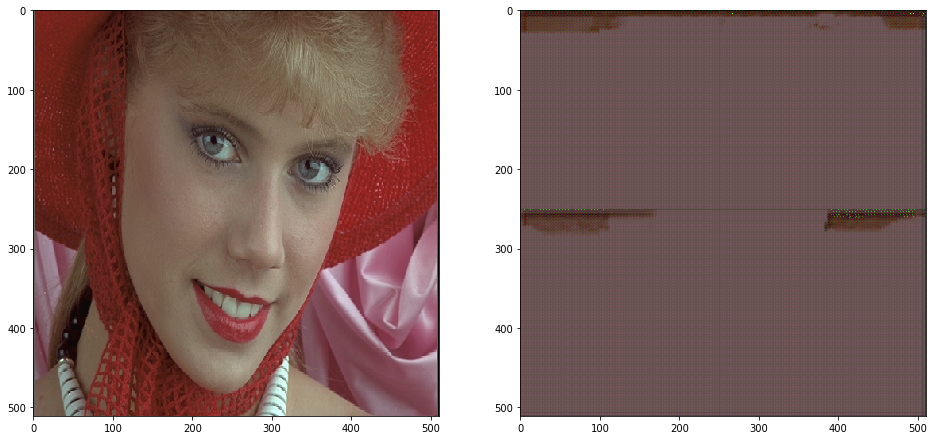

In [5]:
model = torch.load('./data_for_visualization/model.pth')
model.to('cpu')
model.eval()
frames, overlay_mask = slicing(np_image, FRAME_SIZE, OVERLAY_SIZE)

predicted_frames = []
num_pool_layers = 2
latent_vector_size = frames[0].shape[0] * frames[0].shape[0] // 4 ** num_pool_layers
data = np.zeros((len(frames), latent_vector_size), dtype=float)
latent_matrix = torch.tensor(data=data, dtype=torch.float32, device="cpu")
# print(latent_matrix.shape)
for idx, frame in enumerate(frames):
    with torch.set_grad_enabled(False):
        tens = ToTensor()(np.array(frame)).unsqueeze(0)/1.0
        latent_vector = torch.cat((model(tens)[0], model(tens)[1]), dim=3)
        latent_matrix[idx,:] = latent_vector
        predicted_frame = model.decoder(torch.cat((model(tens)[0], 0*model(tens)[1]), dim=3)).squeeze()
    predicted_frames.append(ToNumpy()(predicted_frame))
predicted_image = gluing(predicted_frames, overlay_mask, OVERLAY_SIZE)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 9))
axes[0].imshow(Image.fromarray(np_image))
axes[1].imshow(Image.fromarray(predicted_image))

In [6]:
numpy_latent_matrix = latent_matrix.cpu().detach().numpy()

In [7]:
sum_latent_vector = np.sum(numpy_latent_matrix, axis=0)

In [8]:
savepath = "./data_for_visualization/plots/"
Path(savepath).mkdir(parents=True, exist_ok=True)

In [9]:
CountPlot(sum_latent_vector, savepath + f"sum_latent_vector_count.png")
BarhPlot(sum_latent_vector, savepath + f"sum_latent_vector_barh.png")

In [10]:
from pathlib import Path

for i in range(numpy_latent_matrix.shape[0]):
    numpy_latent_vector = numpy_latent_matrix[i]
    CountPlot(numpy_latent_vector, savepath + f"{i}th_frame_latent_vector_count.png")
    BarhPlot(numpy_latent_vector, savepath + f"{i}th_frame_latent_vector_barh.png")